In this tutorial, you will use `ParticleInCell2` to model one of the simplest phenomena in
plasma physics: an electrostatic (or Langmuir) oscillation. This tutorial is part of a
series of examples that uses `ParticleInCell2` to demonstrate the basic plasma physics
concepts that are covered in [Birdsall and Langdon's classic PIC textbook](@cite
birdsall2004).

A Langmuir oscillation occurs when a slab of charge in a uniform plasma is
displaced. The resulting charge density gradient creates a restoring force
that causes the displaced slab of charge to return to its original position.
But---just as in a classical pendulum oscillation---the momentum of the
charge carries it past its equilibrium point, creating an opposite charge
gradient, and a restoring force in the opposite direction. As a result, the
slab of charge oscillates around its equilibrium forever (at least in this
idealized model that ignores possible damping mechanisms).
For a plasma composed of a single mobile species $s$ with mass $m_s$ and charge
$q_s$, the frequency of this oscillation is given by
$$
\omega_{p,s} = \sqrt{\frac{n_s q_s^2}{\epsilon_0 m_s}}
$$
where $n_s$ is the number density of the plasma and $\epsilon_0$ is the permitivity of
free space. Notice that the plasma frequency has a $m_s^{-1/2}$ dependence, and thus the
lightest species (typically electrons) will dominate the dynamics of a plasma oscillation.
For this reason, we will only model the dynamics of the electrons in our simulation.

We begin by loading the `ParticleInCell2` package. Additionally, we load `CairoMakie`
which is a backend for [`Makie`](https://makie.org) that can generate beautiful,
publication-quality graphics.

In [1]:
using ParticleInCell2
using CairoMakie
CairoMakie.activate!(type = "svg") # hide

We begin by creating some electrons to move in the simulation. For even a tiny simulation
volume, there are *far* too many physical electrons to simulate each one individually.
Instead, PIC algorithms group physical particles into 'macroparticles'. The distribution
of macroparticles in phase space serves as an approximation for the phase space
distribution of physical particles. We arbitrarily choose a simulation domain of length
one, and a nominal electrons number density of $10^{14}$. Then, for a given number of
macroparticles, we can calculate the number of physical electrons represented by each.

In [2]:
sim_length = 1.0
nom_density = 1e14
num_macroparticles = 320
particles_per_macro = nom_density * sim_length / num_macroparticles

3.125e11

We distribute the macroparticles evenly across the simulation domain.

In [3]:
positions = collect(0:num_macroparticles-1) ./ num_macroparticles;

In order to seed a Langmuir oscillation, we give the electrons a sinusoidal velocity
perturbation. This corresponds to the moment in a Langmuir oscillation when the slab of
charge has reached equilibrium, but is being carried past by its momentum. This
perturbation is defined by a wavenumber `k` and an `amplitude`.

In [4]:
k = 1
amplitude = 1e3
elec_mass = 9e-31
momentums = (particles_per_macro * elec_mass * amplitude) .* sin.(positions .* k .* 2pi);

We can visualize the initial condition of the electron macroparticle by plotting the
initial phase space.

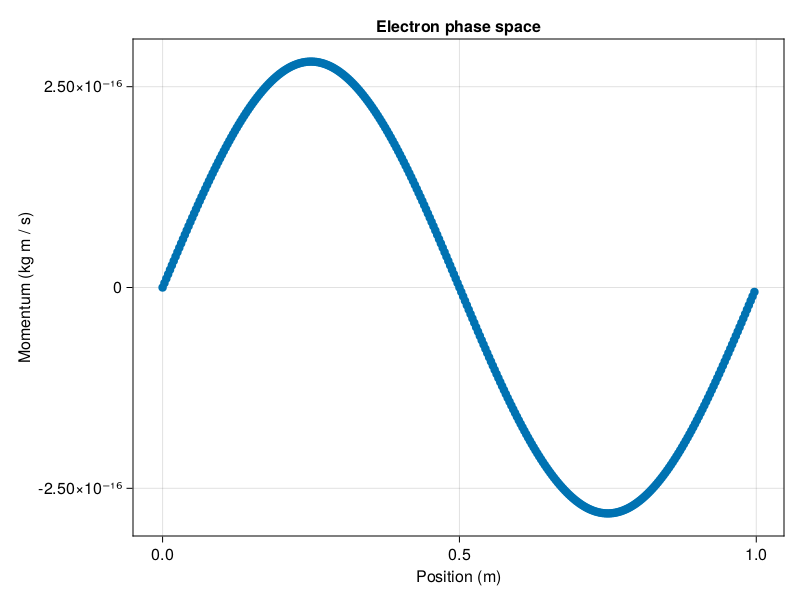

In [5]:
scatter(
    positions,
    momentums;
    axis = (;
        title = "Electron phase space",
        xlabel = "Position (m)",
        ylabel = "Momentum (kg m / s)",
    ),
)

Finally, we create a `VariableWeightSpecies` which holds the all of the
macroparticles. Additionally, we must pass the value of
`particles_per_macro`, which is used to calculate the charge and mass of the
macroparticles.

In [6]:
electrons = ParticleInCell2.electrons(positions, momentums, particles_per_macro);

Now we address the 'cell' piece of particle-in-cell by creating a `grid`. Because Langmuir
oscillations are a one-dimensional phenomena, we will choose to perform a 1D simulation.

The choice of grid resolution is determined by the scale of the smallest relevant dynamics
begin simulated. For a Langmuir oscillation, the scale of the dynamics is set by `k`, and
so the simulation could likely accomplished with as few as 4 or 8 cells. However, this is
not a computationally demanding simulation, and so we arbitrarily choose to use 32 equally
spaced (i.e. uniform) grid points. Additionally, we make the simulation domain periodic.

In [7]:
num_cells = 32
dx = sim_length / num_cells
periodic = true
grid = UniformCartesianGrid((0.0,), (sim_length,), (num_cells,), (periodic,));

Next, we set up the required fields for an electrostatic PIC simulation. In
a basic PIC cycle, we first compute the charge density, `rho`, on the grid
points. We then compute the corresponding electric potential, `phi`. The
electric field is conventionally determined in a two step process. First the
potential, which is located at the nodes of the grid cells, is finite
differenced to the edges of the cells, producing an edge electric field,
`Eedge`. The edge electric fields are then averaged to get the electric fields
located at the nodes, `Enode`.

When creating the fields, we must specify the underlying grid on which the
field is based, the location of the values of the field (i.e. are the field
values located at the nodes of each cell? The edge?), the dimension of the
field, and the number of guard cells surrounding the field.

In [8]:
field_dimension = 1
lower_guard_cells = 1
rho = Field(grid, ParticleInCell2.node, field_dimension, lower_guard_cells)
phi = Field(grid, ParticleInCell2.node, field_dimension, lower_guard_cells)
Eedge = Field(grid, ParticleInCell2.edge, field_dimension, lower_guard_cells)
Enode = Field(grid, ParticleInCell2.node, field_dimension, lower_guard_cells);

At this point, we must choose a timestep for the simulation. We would like to use a large
timestep so that more of the systems dynamics can be observed with the same number of
steps. However, we must resolve the fastest timescale of the dynamics that we are trying
to simulate. In this case, we must resolve the plasma frequency. Additionally, we must
choose a timestep that is short enough that particles do not cross more than one cell per
timestep to prevent numerical instabilities from arising. For the oscillation amplitude
that we have chosen, the particles do not move fast enough for the CFL condition to
matter, and so we will choose our timestep based on the expected plasma frequency.

In [9]:
epsilon_0 = 8.8e-12
elec_charge = 1.6e-19
elec_mass = 9e-31
expected_plasma_freq = sqrt(nom_density * elec_charge^2 / elec_mass / epsilon_0)
expected_plasma_period = 2pi / expected_plasma_freq

1.1051531770007306e-8

Once again, this is not a computationally demanding simulation, and so we will choose a
relatively small timestep for improve numerical accuracy. You can play with increasing
the timestep, and see when the simulation results begin to deteriorate.

In [10]:
dt = 5e-11

5.0e-11

In the final step of the setup, we create all of the simulation steps
required to do the electrostatic simulation. In this tutorial, we will not
discuss the details of PIC simulation, but you can find more information about
the PIC simulation cycle elsewhere in this documentation.

In [11]:
charge_interp = BSplineChargeInterpolation(electrons, rho, 1)
comm_rho = CommunicateGuardCells(rho, true)
field_solve = PoissonSolveFFT(rho, phi)
comm_phi = CommunicateGuardCells(phi)
finite_diff = FiniteDifferenceToEdges(phi, Eedge)
comm_Eedge = CommunicateGuardCells(Eedge)
elec_ave = AverageEdgesToNodes(Eedge, Enode)
comm_Enode = CommunicateGuardCells(Enode)
push = ElectrostaticParticlePush(electrons, Enode, dt)
comm_electrons = CommunicateSpecies(electrons, grid);

Now we are ready to run the simulation. We will simulate the plasma for 1000
timesteps, and at each step, we will calculate the electric field energy,
$$
U_E = \int |E(x)|^2 \,\mathrm{d}x.
$$
This field energy will oscillate as the electrons move in and out of
equilibrium, and so we can use it to observe the Langmuir oscillation.

In [12]:
n_steps = 1000

electric_field_energy = Vector{Float64}(undef, n_steps)

for n = 1:n_steps
    # Calculate the electric field energy
    electric_field_energy[n] = 0
    for I in eachindex(Enode)
        electric_field_energy[n] += (dx * epsilon_0 / 2) * (Enode.values[I])^2
    end

    # TODO
    rho.values .= 0

    step!(charge_interp)
    step!(comm_rho)
    step!(field_solve)
    step!(comm_phi)
    step!(finite_diff)
    step!(comm_Eedge)
    step!(elec_ave)
    step!(comm_Enode)
    step!(push)
    step!(comm_electrons)
end

We can now visualize the electric field energy to see the plasma oscillation.

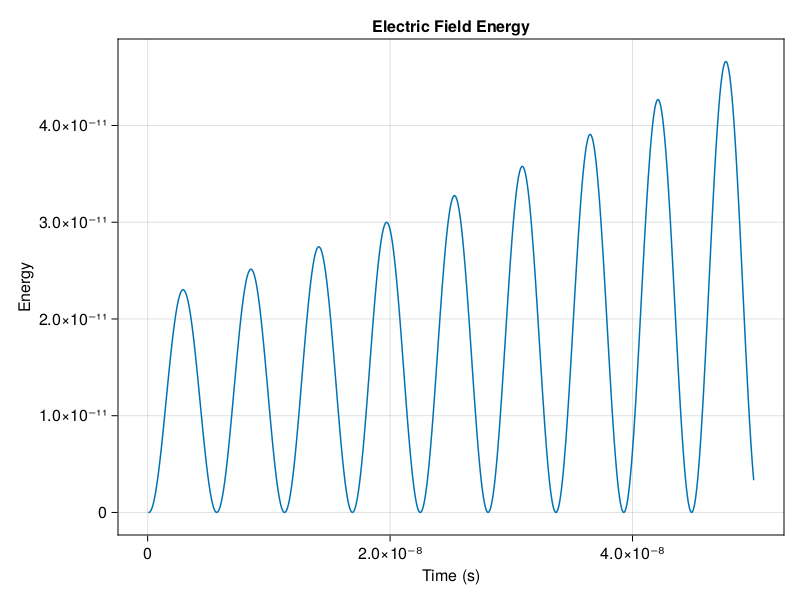

In [13]:
times = collect(range(1, n_steps)) .* dt
lines(
    times,
    electric_field_energy;
    axis = (; title = "Electric Field Energy", xlabel = "Time (s)", ylabel = "Energy"),
)

Notice that the electric field energy is slowly growing over time. This is a
result of the "grid-heating instability". In this instability, a plasma with
a Debye length (the characteristic length with which the plasma will screen
an applied electric field) shorter than the cell size will be unphysically
heated until the Debye length is comparable to the cell size. Because we
initialized the electrons with only a sinusoidal velocity perturbation, and
no thermal spread in the momentum distribution, the Debye length is
effectively zero, and thus the simulation suffers from grid heating.

Despite this unphysical effect, we can still use the electric field energy
time series to calculate the plasma frequency by computing its Fourier
transform. First, let's plot the Fourier transform.

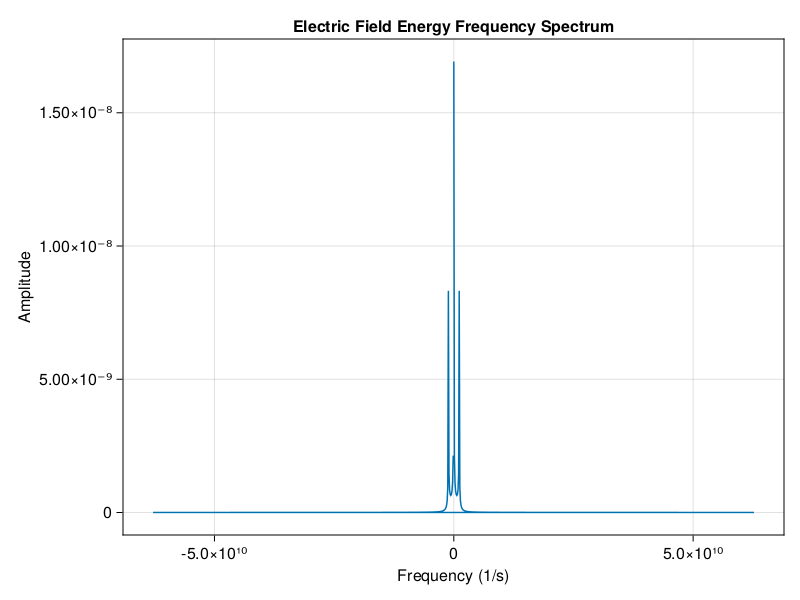

In [14]:
using FFTW

freqs = fftfreq(n_steps, 1 / dt) .* 2pi
freq_amps = abs.(fft(electric_field_energy))

lines(
    freqs,
    freq_amps;
    axis = (;
        title = "Electric Field Energy Frequency Spectrum",
        xlabel = "Frequency (1/s)",
        ylabel = "Amplitude",
    ),
)

It is hard to see what is happening at the low frequencies, so let's zoom
in on the positive low frequencies.

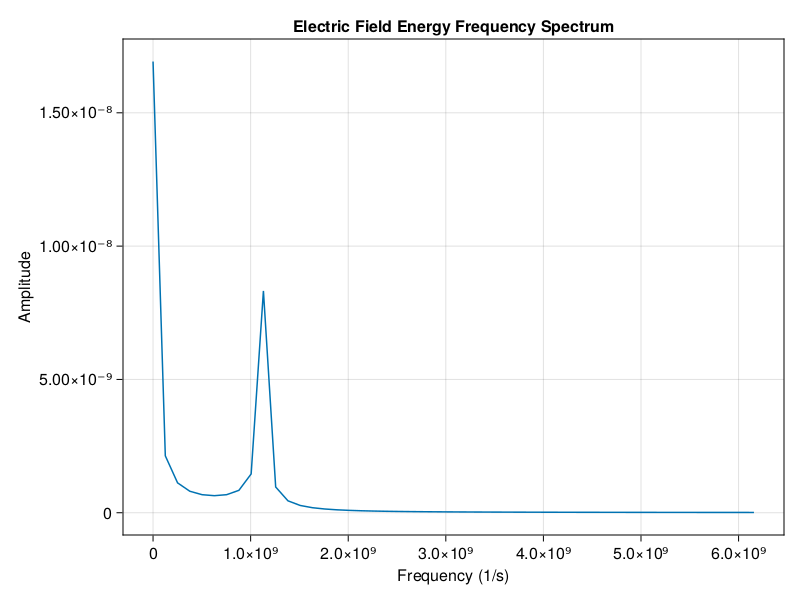

In [15]:
cutoff_index = round(Int, n_steps * 0.05)
lines(
    freqs[1:cutoff_index],
    freq_amps[1:cutoff_index];
    axis = (;
        title = "Electric Field Energy Frequency Spectrum",
        xlabel = "Frequency (1/s)",
        ylabel = "Amplitude",
    ),
)

Next, we find the maximum frequency. We don't care about the spike at zero frequency (that
is just a consequence of the electric field energy being a strictly positive quantity) so
we first set its amplitude to zero, and then find the largest remaining amplitude, and
it's corresponding frequency.

In [16]:
freq_amps[1] = 0
max_index = findmax(freq_amps)[2]
max_freq = freqs[max_index]

# Divide by 2 because the electric field energy goes through a maximum twice
# per plasma oscillation, and take the absolute value because we don't care
# about the phase of the oscillation.
plasma_freq = abs(max_freq / 2)

5.654866776461627e8

Finally, we can compare this to the theoretically expected result:

In [17]:
relative_error = (plasma_freq - expected_plasma_freq) / expected_plasma_freq

-0.005362140699342522

Less than 1% error. Not bad!

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*